In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import statsmodels.api as sm
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv(
    "https://github.com/fbranda/monkeypox-opendata/raw/main/ECDC-WHO/Epicurves/epicurve_by_country.csv",
    parse_dates=["Date"], index_col="Date"
)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1494 entries, 2022-06-20 to 2022-08-09
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Country  1494 non-null   object
 1   Cases    1494 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 35.0+ KB


In [4]:
df.Country.unique().size

36

In [5]:
WARNINGS = {
    "country": [],
    "1st cases": [],
    "max incidence": [],
    "length": []
}
DATA = {
    "country": [],
    "1st cases": [],
    "max incidence": [],
    "length": [],
    "max_date": [],
}

for c in df.Country.unique():
    _df = df[df.Country==c]
    WARNINGS["country"].append(c)
    DATA["country"].append(c)
    
    DATA["1st cases"].append(_df.Cases[0])
    if _df.Cases[0] > 1:
        WARNINGS["1st cases"].append("WARN")
    else:
        WARNINGS["1st cases"].append("")
    
    DATA["max incidence"].append(_df.Cases.max())
    if _df.Cases.max() < 10:
        WARNINGS["max incidence"].append("ERR")
    elif _df.Cases.max() < 30:
        WARNINGS["max incidence"].append("WARN")
    else:
        WARNINGS["max incidence"].append("")
    
    WARNINGS["length"].append("")
    DATA["length"].append(np.NaN)
    
    DATA["max_date"].append(np.datetime64('NaT'))

In [6]:
WARNINGS = pd.DataFrame(WARNINGS)
DATA = pd.DataFrame(DATA)

In [7]:
countries = WARNINGS[WARNINGS["max incidence"]!="ERR"].country

In [8]:
DATA

,country,1st cases,max incidence,length,max_date
0,Andorra,1,1,NaN,NaT
1,Austria,1,11,NaN,NaT
2,Belgium,1,19,NaN,NaT
3,Bosnia and Herzegovina,1,1,NaN,NaT
4,Bulgaria,1,1,NaN,NaT
5,Croatia,1,3,NaN,NaT
6,Cyprus,1,1,NaN,NaT
7,Czechia,1,3,NaN,NaT
8,Denmark,1,9,NaN,NaT
9,Estonia,1,2,NaN,NaT


In [9]:
WARNINGS

,country,1st cases,max incidence,length
0,Andorra,,ERR,
1,Austria,,WARN,
2,Belgium,,WARN,
3,Bosnia and Herzegovina,,ERR,
4,Bulgaria,,ERR,
5,Croatia,,ERR,
6,Cyprus,,ERR,
7,Czechia,,ERR,
8,Denmark,,ERR,
9,Estonia,,ERR,


In [10]:
DATA[WARNINGS["max incidence"]!="ERR"]

,country,1st cases,max incidence,length,max_date
1,Austria,1,11,NaN,NaT
2,Belgium,1,19,NaN,NaT
11,France,1,106,NaN,NaT
13,Germany,1,90,NaN,NaT
19,Italy,1,21,NaN,NaT
24,Netherlands,1,32,NaN,NaT
27,Portugal,1,18,NaN,NaT
32,Spain,1,135,NaN,NaT
34,Switzerland,1,15,NaN,NaT
35,United Kingdom,1,70,NaN,NaT


In [11]:
WARNINGS[WARNINGS["max incidence"]!="ERR"]

,country,1st cases,max incidence,length
1,Austria,,WARN,
2,Belgium,,WARN,
11,France,,,
13,Germany,,,
19,Italy,,WARN,
24,Netherlands,,,
27,Portugal,,WARN,
32,Spain,,,
34,Switzerland,,WARN,
35,United Kingdom,,,


In [12]:
def sensitivity_analysis(incidence, country, Ts=28, minT=14,
                muLo=None, muUp=None,
                sdLo=None, sdUp=None,
                CI=.95, pairs=100,
                save=True, plot_sim=False, plot_R2=False
               ):
    
    def sh_ra_from_mu_sd(mu, sd):
        """
        Computes shape sh and rate ra for a Gamma distribution
        given the mean mu and the standard deviation sd
        """
        sh = mu**2 / sd**2
        ra = mu / sd**2
        return sh, ra
    
    def simulated_I(r, SI, i, plot=False):
        """
        Simulates an incidence given observed incidence i
        basic reproduction number r and Serial Interval SI
        """
        T = i.size
        sim = np.zeros(T + SI.size)
        for t in range(T):
            sim[t:(t+SI.size)] += r * i[t] * SI
        sim[0] = i[0]
        sim = sim[:T]
        if plot:
            plt.plot(i.values)
            plt.plot(sim)
            plt.title(r)
            plt.show()
        return sim
    
    def fit_epid(inc, SI, r):
        """
        Returns a Poisson log-likelihood for observed incidence
        given basic reproduction number r and Serial Interval SI
        """
        sim = simulated_I(r, SI, inc)
        logPMF = sps.poisson.logpmf(inc[1:], mu=sim[1:])
        logPMF = np.nan_to_num(logPMF, copy=True, neginf=0)
        #plt.plot(inc, logPMF, "o")
        #plt.show()
        logLik = np.sum(logPMF)
        return logLik
    
    def maximize_logLik(inc, SI, size=100, plot=False):
        """
        Maximizes Poisson log-likelihood for observed incidence
        given Serial Interval SI and a range of basic reproduction 
        numbers from 0.01 to 10
        """
        ran = np.logspace(np.log(.01), np.log(10), size, base=np.exp(1))
        Ps = []
        for r in ran:
            P = fit_epid(inc, SI, r)
            Ps.append(P)
        Ps = np.array(Ps)
        P_max_idx = np.argmax(Ps)
        P_max = Ps[P_max_idx]
        R_max = ran[P_max_idx]
        if plot:
            with plt.style.context("ggplot"):
                fig, ax = plt.subplots(figsize=(15, 4))
                plt.plot(ran, Ps, "o")
                plt.axvline(R_max, ls="--")
                plt.axhline(P_max, ls="--")
                plt.show()
        return {"R": R_max, "logP": P}
    
    def deviance_R2(obs, R, si):
        """
        Computes deviance R2 for an observed incidence obs given
        a predicted incidence pred
        """
        pred = simulated_I(R, si, obs)
        mod = sm.GLM.from_formula(
            "I ~ sim",
            family=sm.families.Poisson(),
            data=pd.DataFrame({"I":obs, "sim":pred})
        )
        res = mod.fit()
        r2 = (res.null_deviance - res.deviance) / res.null_deviance
        return {"R2":r2, "pred":pred}
        
    
    # define mu parameters for Truncated Normal distribution  
    mu_mu = (muUp+muLo)/2
    mu_sd = (muUp-muLo)/2/sps.norm.ppf((1+CI)/2)
    mua, mub = (muLo - mu_mu) / mu_sd, (muUp - mu_mu) / mu_sd
    mu_d = sps.truncnorm(loc=mu_mu, scale=mu_sd, a=mua, b=mub)
    # define sd parameters for Truncated Normal distribution  
    sd_mu = (sdUp+sdLo)/2
    sd_sd = (sdUp-sdLo)/2/sps.norm.ppf((1+CI)/2)
    sda, sdb = (sdLo - sd_mu) / sd_sd, (sdUp - sd_mu) / sd_sd
    sd_d = sps.truncnorm(loc=sd_mu, scale=sd_sd, a=sda, b=sdb)
    # sample (mu,sd) pairs
    mu_rvs = mu_d.rvs(pairs)
    mu_sd = []
    for mu_r in mu_rvs:
        sd_r = sd_d.rvs(1)
        while(sd_r >= mu_r):
            sd_r = sd_d.rvs(1)
        mu_sd.append([mu_r, sd_r[0]])
    mu_sd = np.array(mu_sd)

    RES = []
    
    Ts_range = np.arange(Ts)
    #print(Ts_range)
    
    for T in tqdm(Ts_range):
        
        if T < minT:
            RES.append(np.nan)
            continue

        #try: #######################################################
        # define incidence time window
        I = incidence.Cases[:(T+1)]

        # method
        # alpha posterior
        a = 1 + np.sum(I[1:])
        # loop through (mu,sd) pairs
        R2 = []
        sims = []
        for ms in tqdm(mu_sd, leave=False):
            # SI gamma distribution
            sh, ra = sh_ra_from_mu_sd(ms[0], ms[1])
            dis = sps.gamma(a=sh, scale=1/ra)
            si = dis.pdf(np.arange(T+1))
            # normalize SI distribution to sum to 1
            si /= si.sum()
            R_l = maximize_logLik(I, si, plot=False)
            R = R_l["R"]
            r2_pred = deviance_R2(I, R, si)
            if plot_sim:
                sims.append(r2_pred["pred"])
            R2.append(r2_pred["R2"])
        if plot_sim:
            with plt.style.context("ggplot"):
                fig, ax = plt.subplots(figsize=(12, 4))
                ax.plot(I.values, label="original")
                for i, sim in enumerate(sims):
                    ax.plot(sim, label="simulated" if not i else None, alpha=.1, color="k")
                plt.title(f"{country}: simulated incidence, window {T}")
                plt.legend()
                plt.show()
        median_R2 = np.median(R2)
        if plot_R2:
            with plt.style.context("ggplot"):
                fig, ax = plt.subplots(figsize=(12, 4))
                plt.hist(R2, alpha=.25)
                plt.axvline(median_R2, ls="--")
                plt.title(f"{country}, deviance R2, window {T}")
                plt.show()
        RES.append(median_R2)
        #except Exception as e: #######################################################
        #    print(country, T, e)
        #    RES.append(0)


    maxR2i = np.argmax(pd.DataFrame({"u": RES}).fillna(0).u.values)
    with plt.style.context("bmh"):
        fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        ax[0].plot(Ts_range, RES)
        ax[0].plot(Ts_range[maxR2i], RES[maxR2i], "or")
        ax[0].axvline(Ts_range[maxR2i], ls="--", color="r")
        ax[0].set_title(f"{country} best time window {Ts_range[maxR2i]+1}, deviance $R^2$: {RES[maxR2i]:.3f}")
        ax[1].set_xlabel("Days from outbreak to maximum observed incidence")
        ax[0].set_ylabel("Deviance R-squared")
        ax[1].plot(I.reset_index().Cases)
        ax[1].axvline(Ts_range[maxR2i], ls="--", color="r")
        ax[1].set_title("Observed incidence")
        ax[1].set_ylabel("Daily new cases")
        if save:
            fig.savefig(f"plots/figure4/R2 {country}.pdf", bbox_inches="tight")
        plt.show()

    return (RES, Ts_range[maxR2i])

In [13]:
def interpolate_to_zero(_df, country, plot=False):
    missing_dates = pd.date_range(_df.index[0], _df.index[-1]).difference(
        _df.index
    )
    missing_dates_num = missing_dates.size
    print(f"{country}: missing {missing_dates_num} dates")
    if missing_dates_num:
        I = _df.resample("D").mean()
        I.fillna(0, inplace=True)
        #I.iloc[0]["Cases"] = _df.iloc[0]["Cases"]
        #I["Cases"] = np.round(I.Cases).astype(int)
        I["Cases"] = I.Cases.astype(int)
    else:
        I = _df
    if plot:
        with plt.style.context("ggplot"):
            ax = _df.plot(y="Cases", label="original", figsize=(12, 4), marker="o", ls="none")
            I.plot(ax=ax, y="Cases", label="interpolated", lw=1)
            plt.title(country)
            plt.legend()
            plt.show()
    return I

In [14]:
def remove_zeros(df, col, country, lim=10, plot=False):
    index_name = df.index.name
    I = df.reset_index()
    for k, v in I[I[col] == 0].groupby((I[col] != 0).cumsum()):
        occurences = v.index.size
        last_index = v.index[-1]
        print(f'[group {k}]')
        print(v)
        print("-->", occurences)
        print("    [", last_index, "]")
        if occurences > lim:
            I = I.iloc[last_index+1:]
            print("    Removed till index")
        print('\n')
    I.set_index("Date", inplace=True)
    if plot:
        with plt.style.context("ggplot"):
            ax = df.plot(y=col, label="original", figsize=(12, 4), ls=":")
            I.plot(ax=ax, y=col, label="removed zeros", lw=4)
            plt.title(country)
            plt.show()
    return I

In [15]:
def missing_dates(df1, df2, idx, country):
    missing = pd.date_range(
        df1.index[0],
        df1[df1.index==df2.index[idx]].index[0]).difference(
        df1.iloc[:df1.reset_index()[df1.index==df2.index[index[1]]].index[0]+1].index).size
    print(f"\tmissing in window {missing_in_win}")

Austria: missing 29 dates


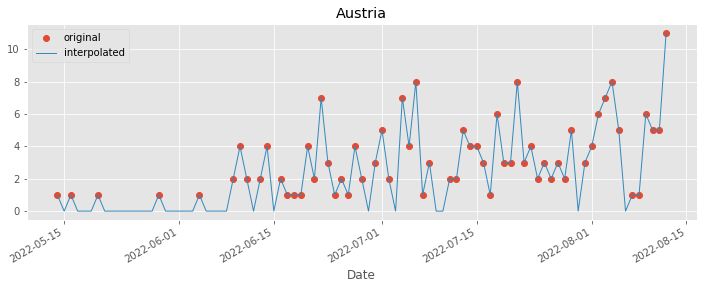

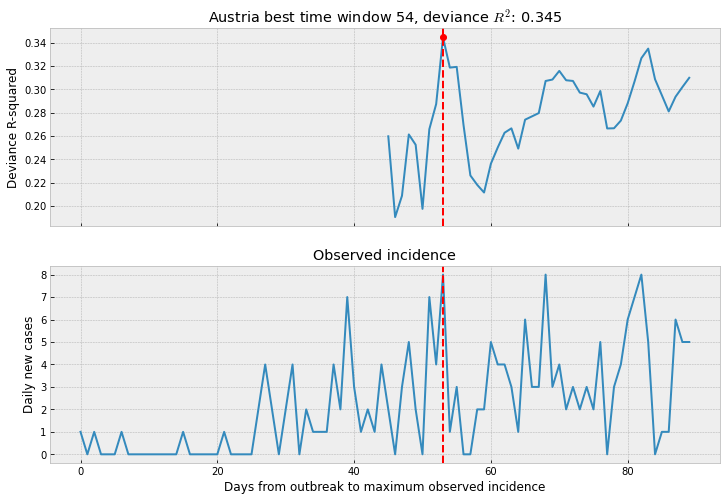

*************************************************
Austria deviance R2 too low!!!
*************************************************
Belgium: missing 5 dates


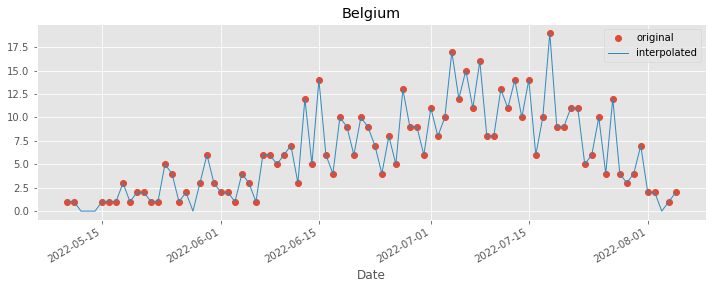

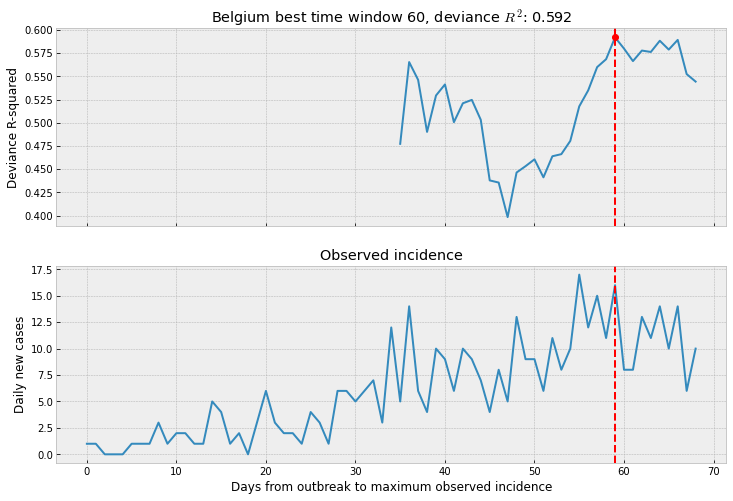

1,1,0,0,0,1,1,1,3,1,2,2,1,1,5,4,1,2,0,3,6,3,2,2,1,4,3,1,6,6,5,6,7,3,12,5,14,6,4,10,9,6,10,9,7,4,8,5,13,9,9,6,11,8,10,17,12,15,11,16
******************************************************



France: missing 3 dates


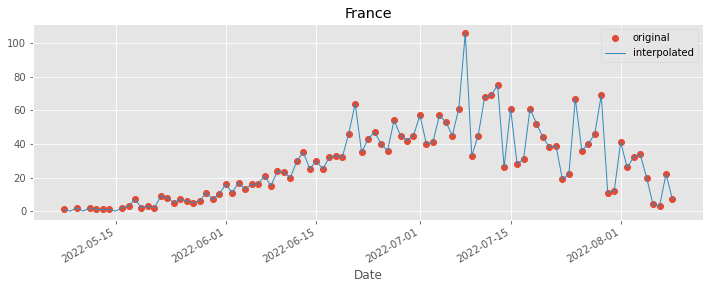

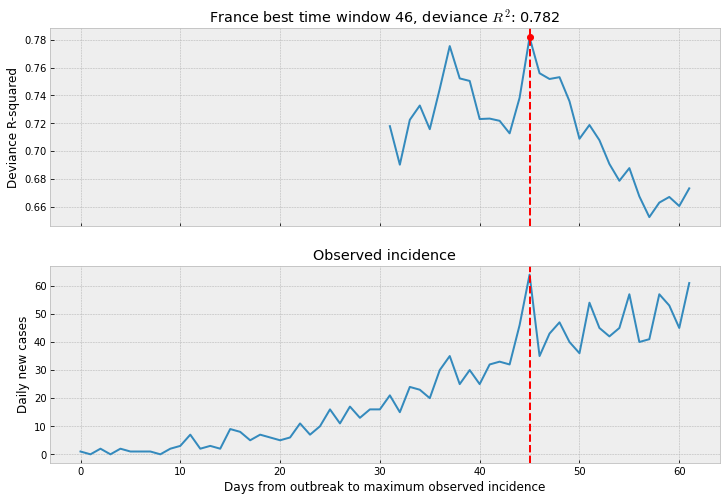

1,0,2,0,2,1,1,1,0,2,3,7,2,3,2,9,8,5,7,6,5,6,11,7,10,16,11,17,13,16,16,21,15,24,23,20,30,35,25,30,25,32,33,32,46,64
******************************************************



Germany: missing 8 dates


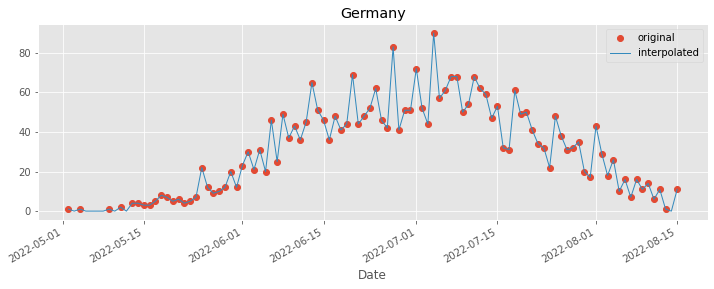

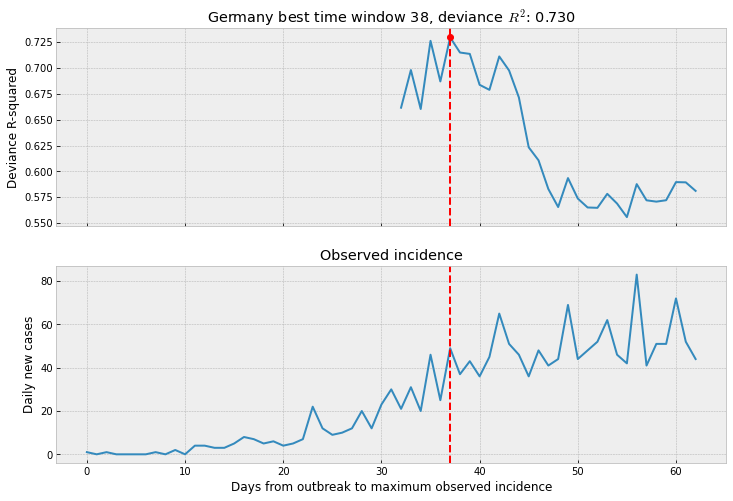

1,0,1,0,0,0,0,1,0,2,0,4,4,3,3,5,8,7,5,6,4,5,7,22,12,9,10,12,20,12,23,30,21,31,20,46,25,49
******************************************************



Italy: missing 42 dates


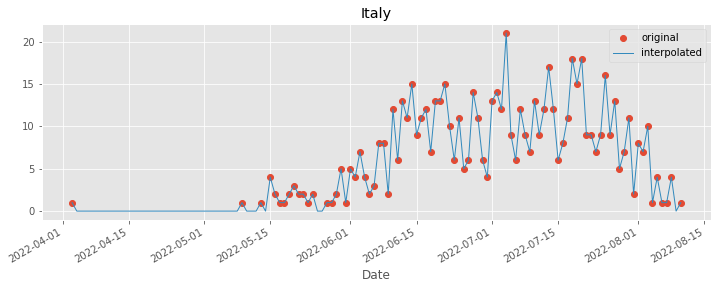

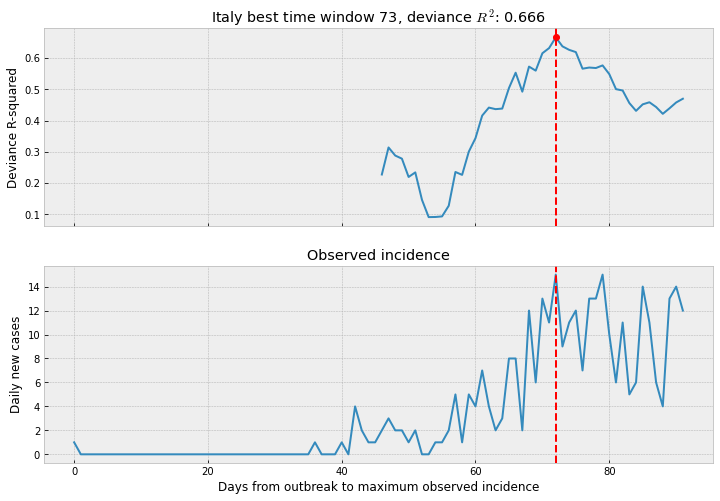

1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,4,2,1,1,2,3,2,2,1,2,0,0,1,1,2,5,1,5,4,7,4,2,3,8,8,2,12,6,13,11,15
******************************************************



Netherlands: missing 14 dates


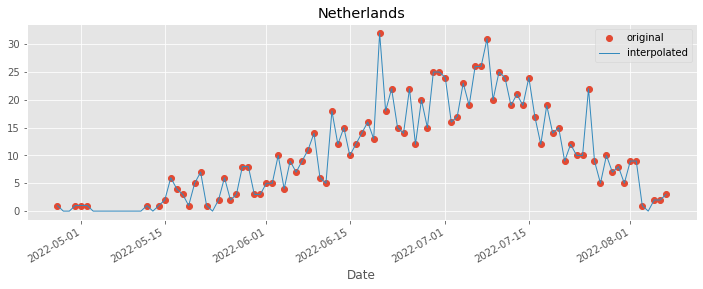

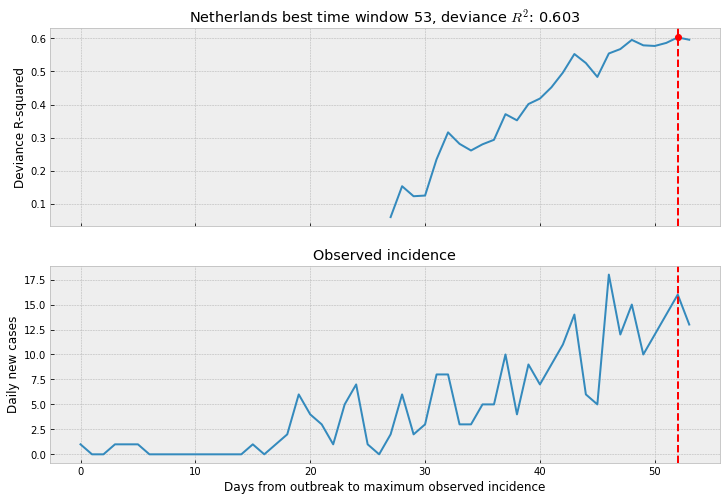

1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,2,6,4,3,1,5,7,1,0,2,6,2,3,8,8,3,3,5,5,10,4,9,7,9,11,14,6,5,18,12,15,10,12,14,16
******************************************************



Portugal: missing 10 dates


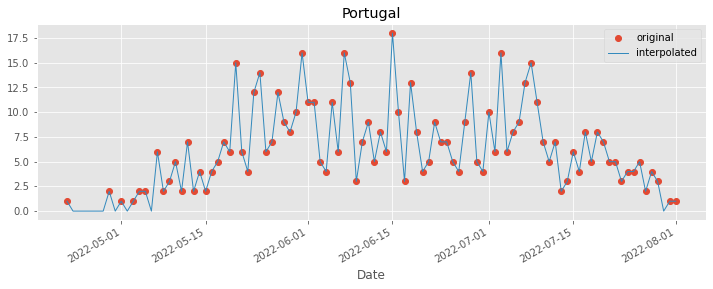

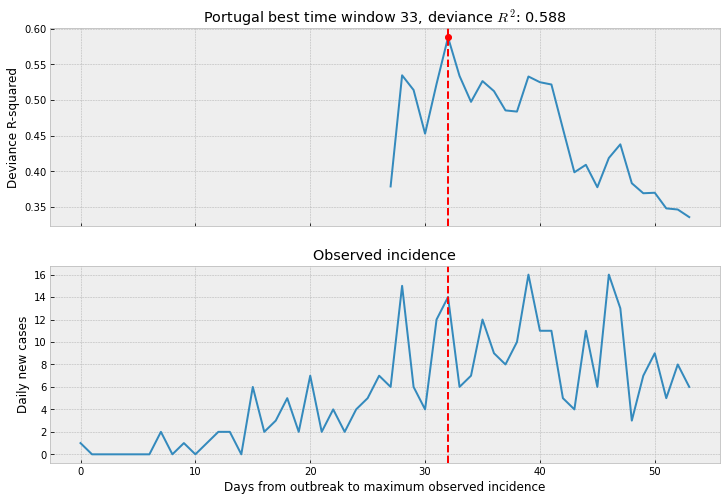

1,0,0,0,0,0,0,2,0,1,0,1,2,2,0,6,2,3,5,2,7,2,4,2,4,5,7,6,15,6,4,12,14
******************************************************



Spain: missing 3 dates


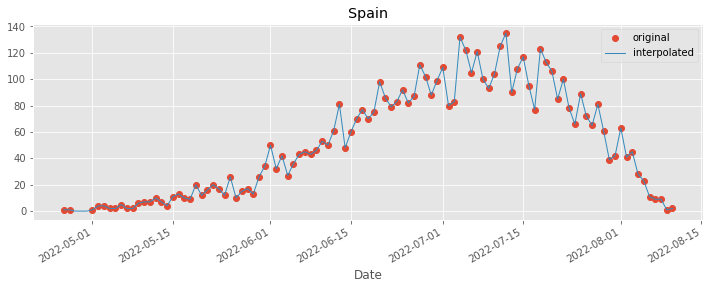

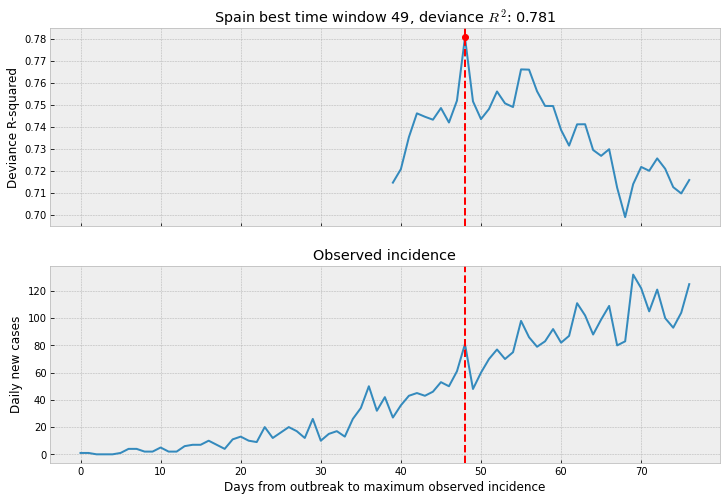

1,1,0,0,0,1,4,4,2,2,5,2,2,6,7,7,10,7,4,11,13,10,9,20,12,16,20,17,12,26,10,15,17,13,26,34,50,32,42,27,36,43,45,43,46,53,50,61,81
******************************************************



Switzerland: missing 9 dates


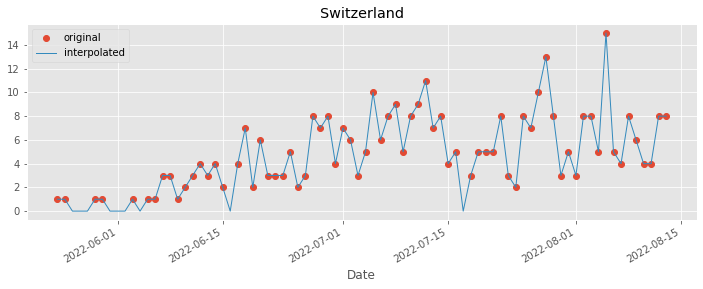

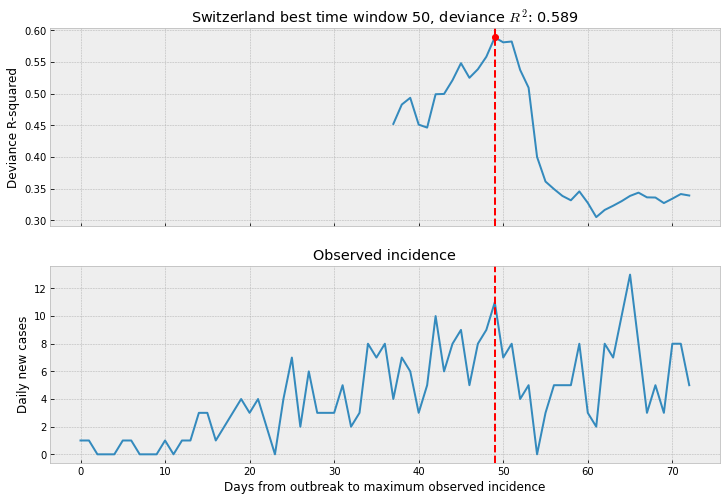

1,1,0,0,0,1,1,0,0,0,1,0,1,1,3,3,1,2,3,4,3,4,2,0,4,7,2,6,3,3,3,5,2,3,8,7,8,4,7,6,3,5,10,6,8,9,5,8,9,11
******************************************************



United Kingdom: missing 48 dates


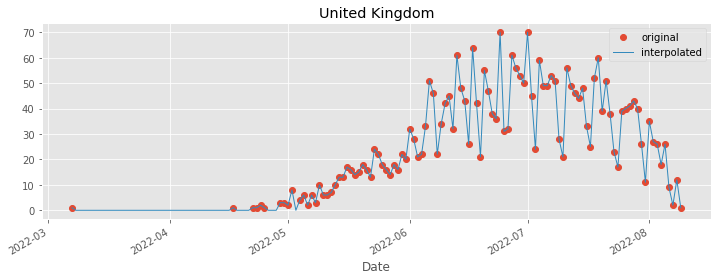

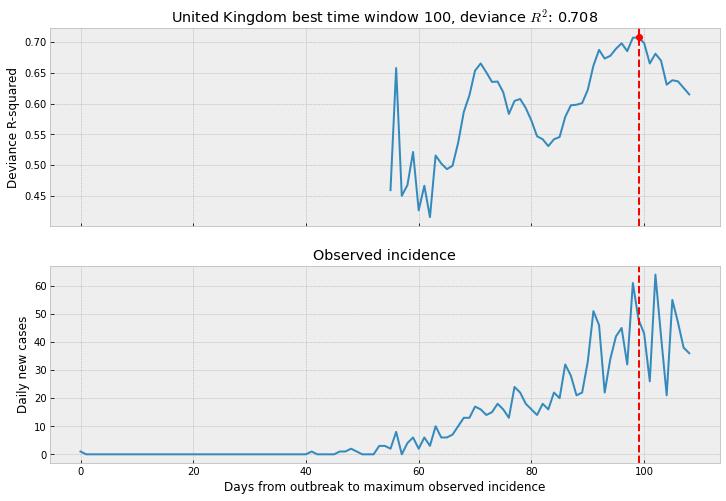

1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,2,1,0,0,0,3,3,2,8,0,4,6,2,6,3,10,6,6,7,10,13,13,17,16,14,15,18,16,13,24,22,18,16,14,18,16,22,20,32,28,21,22,33,51,46,22,34,42,45,32,61,48
******************************************************





In [16]:
DF = None

for country in countries:
    ### TEST ###
    #if country != "Belgium":
    #    continue
    ### TEST ###
    _df = df[df.Country==country]
    I = interpolate_to_zero(_df, country, plot=True)
    #I = remove_zeros(I, "Cases", country, lim=5, plot=True)

    # sensitivity analysis
    maxT = I.reset_index().Cases.idxmax()
    minT = maxT - maxT//2
    #print(minT, maxT)
    index = sensitivity_analysis(
        I, country,
        Ts=maxT,
        minT=minT,
        muLo=7.55, muUp=17.29,
        sdLo=2.88, sdUp=7.26,
        #muLo=12.41, muUp=12.43, #test
        #sdLo=5.069, sdUp=5.071,  #test
        pairs=100, 
        plot_sim=False, #test
        plot_R2=False,  #test
    )
    R2 = index[0][index[1]]
    if R2 < .5:
        print("*************************************************")
        print(country, "deviance R2 too low!!!")
        print("*************************************************")
        continue
    #lim = I.Cases.argmax()        
    lim = index[1]
    DATA.loc[DATA.country==country, "length"] = lim+1
    DATA.loc[DATA.country==country, "max_date"] = I.index[lim]
    I["Country"] = country
    #break #test
    if DF is None:
        DF = I.reset_index().copy(deep=True)
    else:
        DF = pd.concat([DF, I.reset_index()], ignore_index=True)
    
    print(",".join(I.Cases.values[:lim+1].astype(int).astype(str)))
    print("******************************************************")
    print("\n\n")
        
DF.set_index("Date", inplace=True)
    #missing_in_win = pd.date_range(
    #    _df.index[0],
    #    _df[_df.index==I.index[index[1]]].index[0]).difference(
    #    _df.iloc[:_df.reset_index()[_df.index==I.index[index[1]]].index[0]+1].index).size
    #print(f"\tmissing in window {missing_in_win}")
    #DATA.loc[DATA.country==country, "missing dates"] = missing_in_win

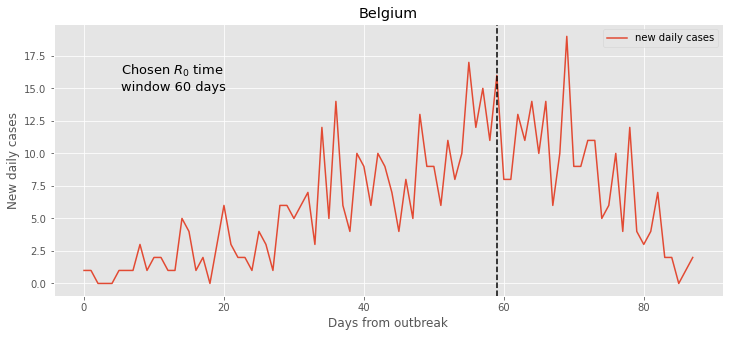

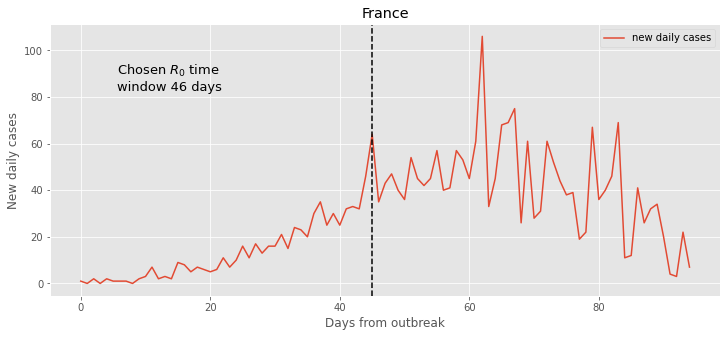

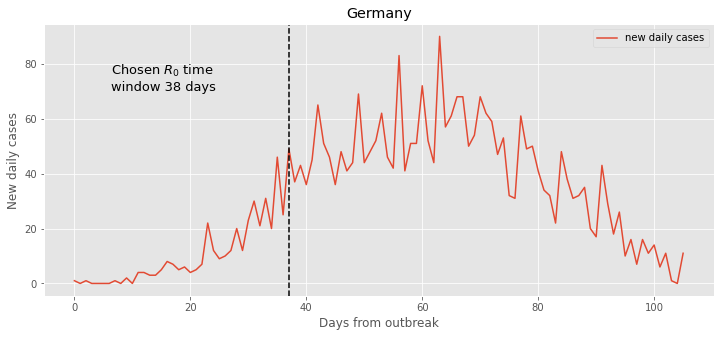

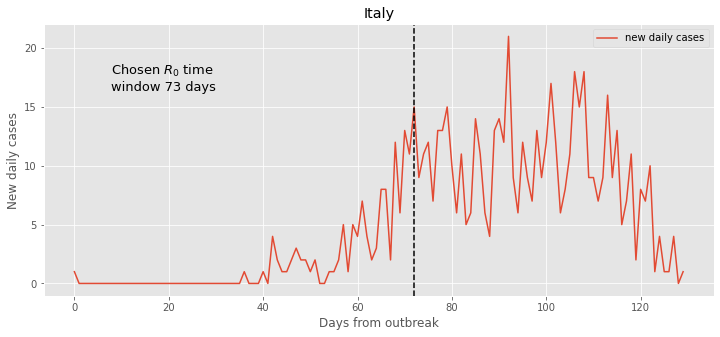

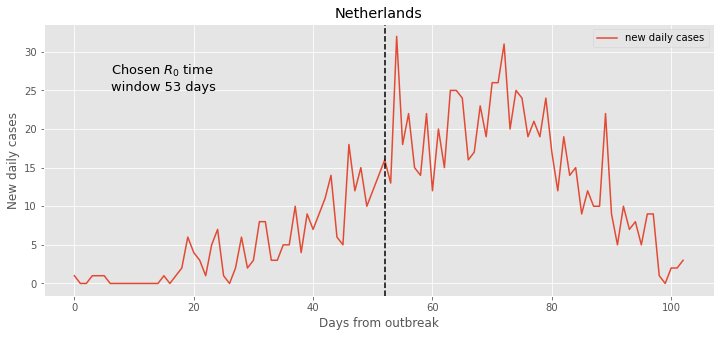

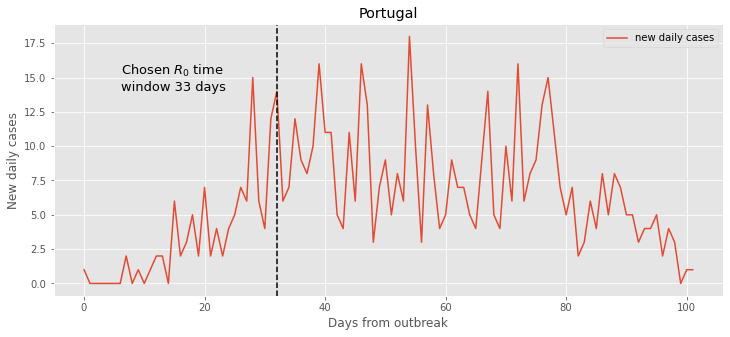

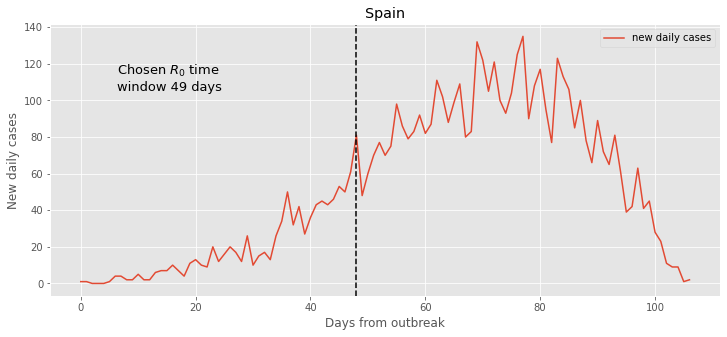

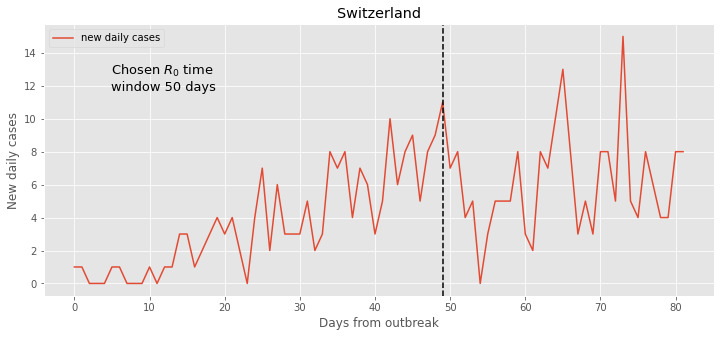

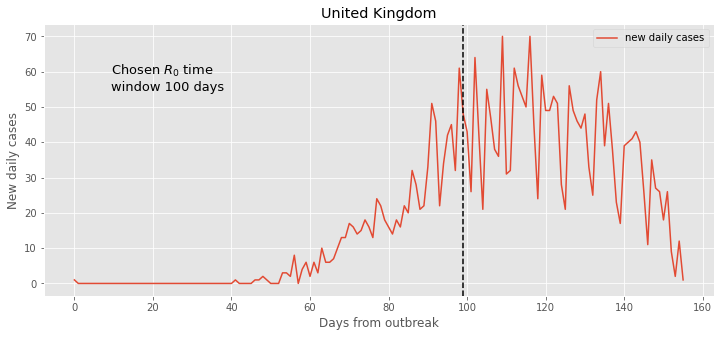

In [51]:
for country in DF.Country.unique():
    try:
        _df = DF[DF.Country==country].reset_index()
        with plt.style.context("ggplot"):
            fig, ax = plt.subplots(figsize=(12, 5))
            ax = _df.plot(y="Cases", title=country, ax=ax, label="new daily cases")
            u = int(DATA.loc[DATA.country==country, "length"].values[0])
            l = DATA.loc[DATA.country==country, "max_date"].values[0]
            ax.axvline(u-1, ls="--", color="k")
            if u < 28:
                WARNINGS.loc[WARNINGS.country==country, "length"] = "WARN"
            #xlim = plt.xlim()
            #ylim = plt.ylim()
            #lox = xlim[0]
            #loy = ylim[0]
            #height = ylim[1] - loy
            #width = l - lox
            #ax.add_patch(Rectangle((lox, loy), width, height, color="g", alpha=.05))
            #plt.xlim(xlim)
            #plt.ylim(ylim)
            #plt.text(
            #    lox+width/2, loy+2*height/3, "Chosen $R_0$ time window",
            #    ha="center", va="center", fontsize=13
            #)
            plt.text(
                .1, .8, f"Chosen $R_0$ time\nwindow {u} days",
                ha="left", va="center", fontsize=13,
                transform=ax.transAxes
            )
            plt.xlabel("Days from outbreak")
            plt.ylabel("New daily cases")
            plt.legend()
            fig.savefig(f"plots/figure1/Window {country}.pdf", bbox_inches="tight")
            plt.show()
    except Exception as e:
        print(country, e)

In [18]:
for c in DF.Country.unique():
    _df = DF[DF.Country==c]
    _df = _df[_df.index<=DATA[DATA.country==c].max_date.values[0]]

    DATA.loc[DATA.country==c, "1st cases"] = _df.Cases[0]
    if _df.Cases[0] > 1:
        WARNINGS.loc[WARNINGS.country==c, "1st cases"] = "WARN"
    else:
        WARNINGS.loc[WARNINGS.country==c, "1st cases"] = ""
        
    DATA.loc[DATA.country==c, "max incidence"] = _df.Cases.max()
    if _df.Cases.max() < 30:
        WARNINGS.loc[WARNINGS.country==c, "max incidence"] = "WARN"
    else:
        WARNINGS.loc[WARNINGS.country==c, "max incidence"] = ""
        
    DATA.loc[DATA.country==c, "length"] = _df.Cases.size
    if _df.Cases.size < 28:
        WARNINGS.loc[WARNINGS.country==c, "length"] = "WARN"
    else:
        WARNINGS.loc[WARNINGS.country==c, "length"] = ""

In [19]:
DATA

,country,1st cases,max incidence,length,max_date
0,Andorra,1,1,NaN,NaT
1,Austria,1,11,NaN,NaT
2,Belgium,1,17,60.0,2022-07-08
3,Bosnia and Herzegovina,1,1,NaN,NaT
4,Bulgaria,1,1,NaN,NaT
5,Croatia,1,3,NaN,NaT
6,Cyprus,1,1,NaN,NaT
7,Czechia,1,3,NaN,NaT
8,Denmark,1,9,NaN,NaT
9,Estonia,1,2,NaN,NaT


In [20]:
WARNINGS

,country,1st cases,max incidence,length
0,Andorra,,ERR,
1,Austria,,WARN,
2,Belgium,,WARN,
3,Bosnia and Herzegovina,,ERR,
4,Bulgaria,,ERR,
5,Croatia,,ERR,
6,Cyprus,,ERR,
7,Czechia,,ERR,
8,Denmark,,ERR,
9,Estonia,,ERR,


In [21]:
def estimate_R0(incidence, country, T=28,
                sh=None, ra=None,
                mu=None, sd=None,
                muLo=None, muUp=None,
                sdLo=None, sdUp=None,
                CI=.95,
                credible_intervals=[.99, .95, .90, .50],
               ):
    
    def R0_posterior(r, credible_intervals):
        R0 = pd.DataFrame()
        R0["Country"] = [country]
        a, loc, scale = sps.gamma.fit(r)
        R_dis = sps.gamma(a=a, loc=loc, scale=scale)
        R_mu = R_dis.mean()
        R_me = R_dis.median()
        R0["Mean"] = [R_mu]
        R0["Median"] = [R_me]
        quantiles = []
        for ci in credible_intervals:
            lo = (1-ci)/2
            up = 1 - lo
            quantiles.append(lo)
            quantiles.append(up)
        for q in sorted(quantiles):
            R_q = R_dis.ppf(q)
            R0[f"Quantile_{q:.3f}"] = [R_q]
        return R0
    
    def sh_ra_from_mu_sd(mu, sd):
        sh = mu**2 / sd**2
        ra = mu / sd**2
        return sh, ra
    
    def overall_infectivity(incid, SI_y, mu=None, sd=None, plot=False):
        T = incid.size
        _lambda = np.zeros(T)
        _lambda[0] = np.nan
        for t in range(T):
            if not t:
                continue
            _lambda[t] = np.sum(
                SI_y[:t+1] * 
                incid[:t+1][::-1]
            )
        if plot:
            with plt.style.context("ggplot"):
                fig, ax = plt.subplots(figsize=(12, 4))
                plt.plot(incid.index, _lambda)
                plt.plot(incid.index, incid.values)
                plt.title(f"SI: mean {mu:.2f}, sd {sd:.2f}")
                plt.show()
        return _lambda
    
    # define incidence time window
    I = incidence.Cases[:T]
    
    # explored SI
    SIs = []
    
    # method
    # define mu parameters for Truncated Normal distribution  
    mu_mu = (muUp+muLo)/2
    mu_sd = (muUp-muLo)/2/sps.norm.ppf((1+CI)/2)
    mua, mub = (muLo - mu_mu) / mu_sd, (muUp - mu_mu) / mu_sd
    mu_d = sps.truncnorm(loc=mu_mu, scale=mu_sd, a=mua, b=mub)
    # define sd parameters for Truncated Normal distribution  
    sd_mu = (sdUp+sdLo)/2
    sd_sd = (sdUp-sdLo)/2/sps.norm.ppf((1+CI)/2)
    sda, sdb = (sdLo - sd_mu) / sd_sd, (sdUp - sd_mu) / sd_sd
    sd_d = sps.truncnorm(loc=sd_mu, scale=sd_sd, a=sda, b=sdb)
    # sample (mu,sd) pairs
    mu_rvs = mu_d.rvs(1000)
    mu_sd = []
    for mu_r in mu_rvs:
        sd_r = sd_d.rvs(1)
        while(sd_r >= mu_r):
            sd_r = sd_d.rvs(1)
        mu_sd.append([mu_r, sd_r[0]])
    mu_sd = np.array(mu_sd)
    # init R0 array
    R = np.array([])
    # alpha posterior
    a = 1 + np.sum(I[1:])
    # loop through (mu,sd) pairs
    for ms in mu_sd:
        # SI gamma distribution
        sh, ra = sh_ra_from_mu_sd(ms[0], ms[1])
        dis = sps.gamma(a=sh, scale=1/ra)
        si = dis.pdf(np.arange(0,T+1))
        # normalize SI distribution to sum to 1
        si /= si.sum()
        SIs.append({"x":np.arange(0,T+1), "y":si})
        #beta posterior
        b = 1 + np.sum(overall_infectivity(I, si, mu=ms[0], sd=ms[1], plot=False)[1:])
        #for t in range(T)[1:]:
        #    # lambda
        #    lam = I[1:(t+1)][::-1] * si[1:(t+1)]
        #    # beta posterior
        #    b += np.sum(lam)
        # R0 posterior
        R_dis = sps.gamma(a=a, scale=1/b)
        R = np.concatenate([R, R_dis.rvs(1000)])

    # TODO: R > DataFrame with mean, median, mode, .99, .95, .90, .50 CI intervals (+ HDI ?)
    return {"samples": R, "stats": R0_posterior(R, credible_intervals), "explored_SI": SIs}

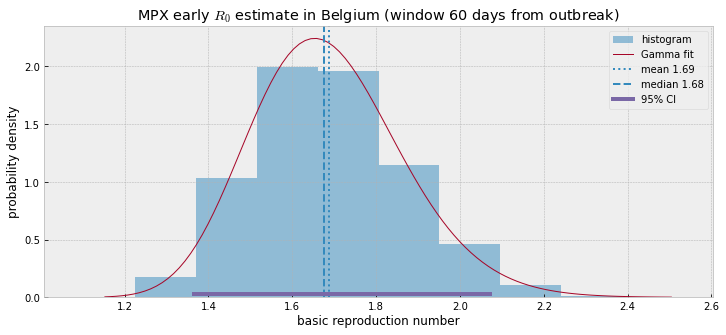

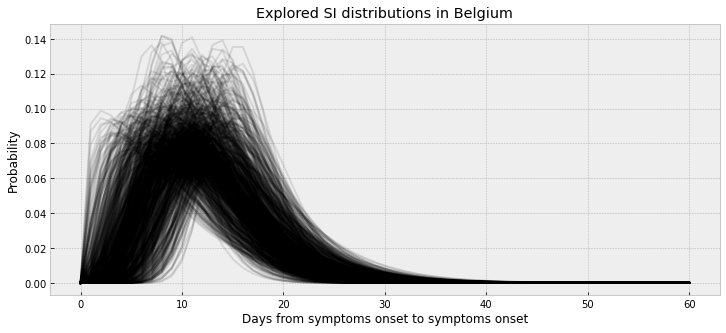

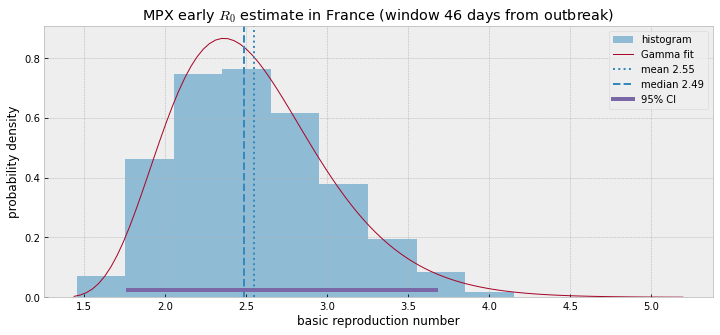

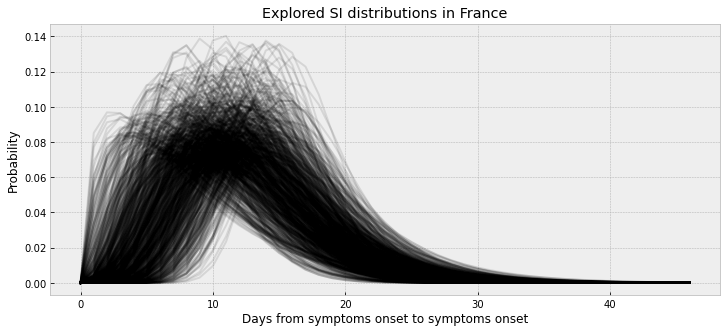

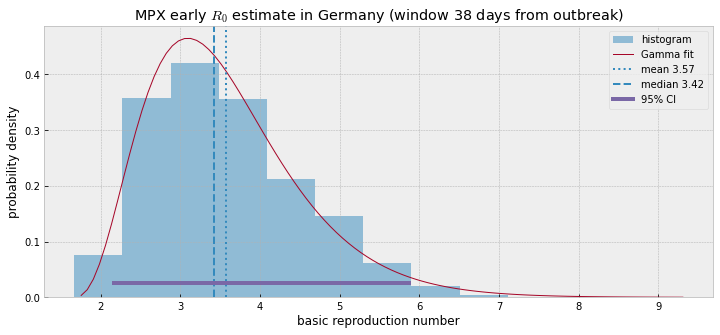

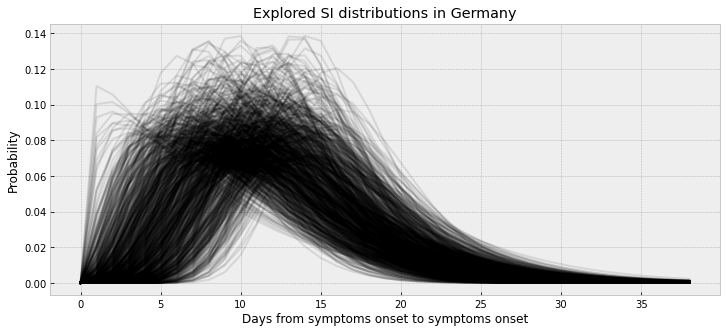

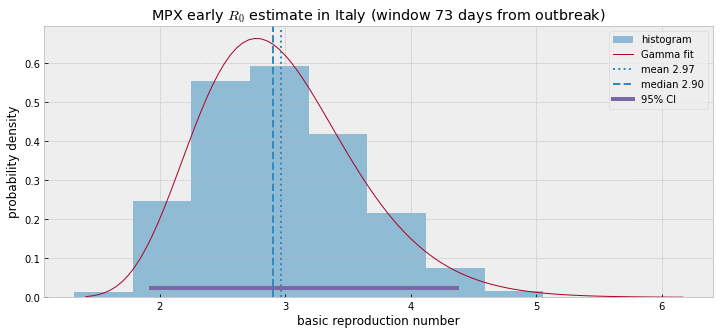

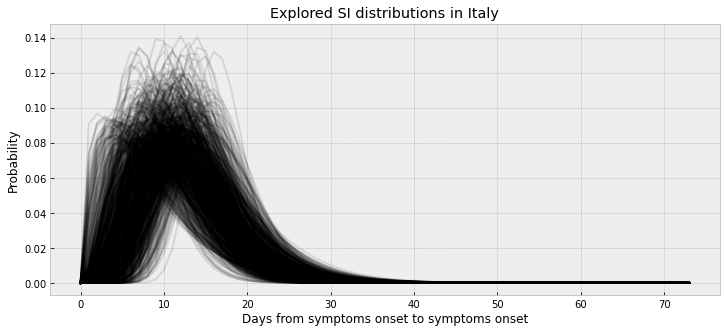

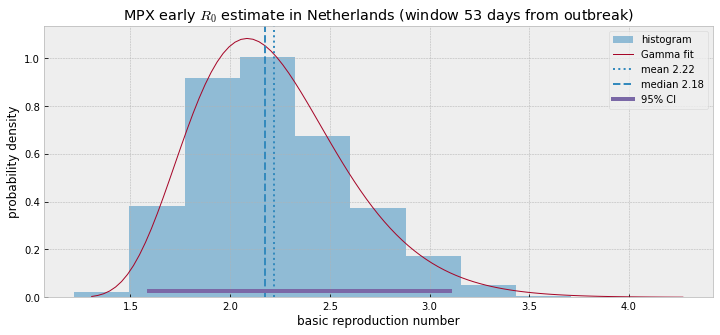

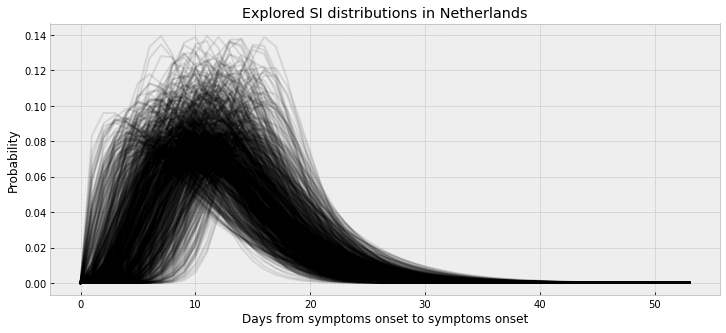

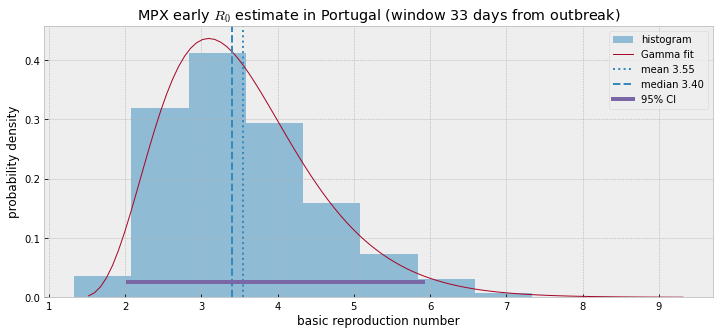

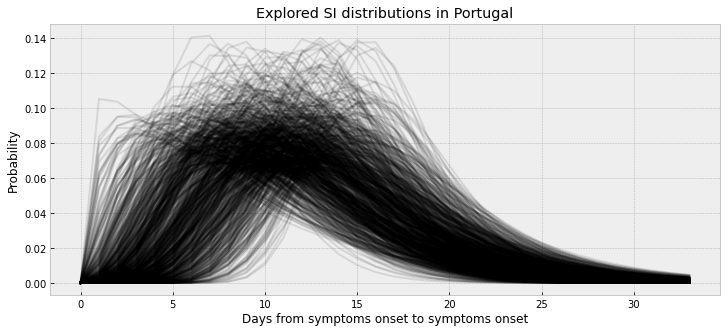

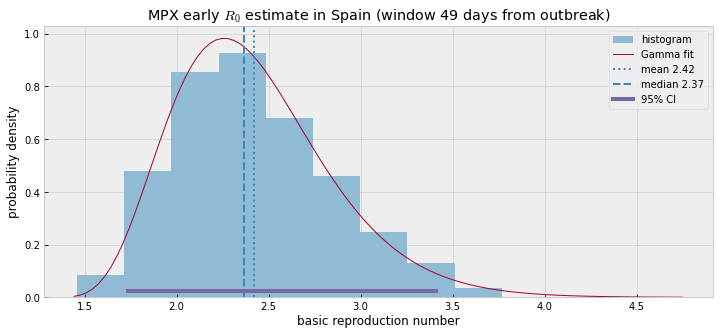

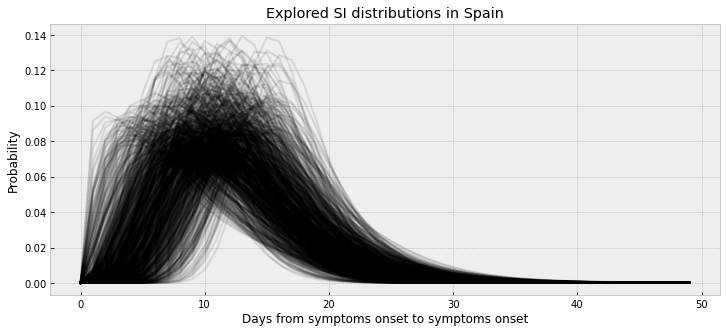

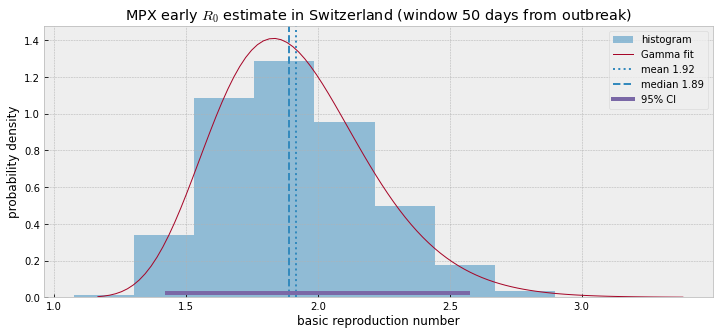

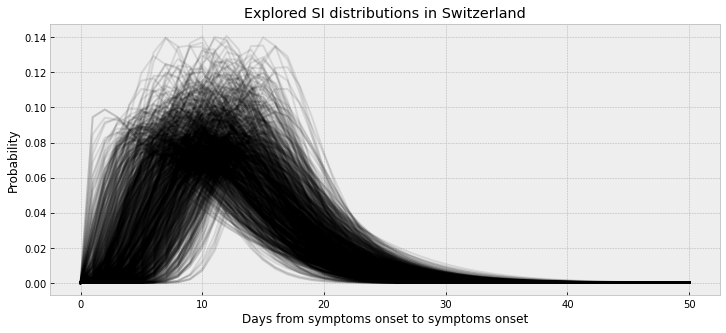

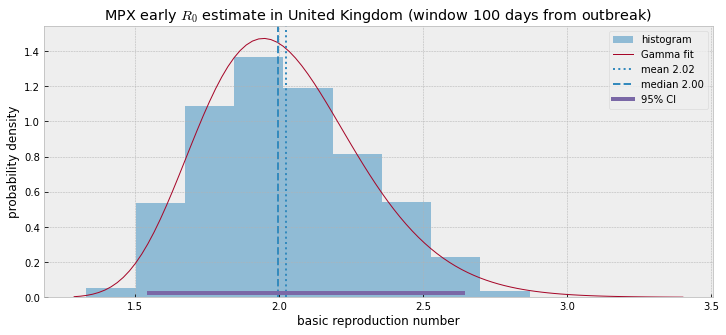

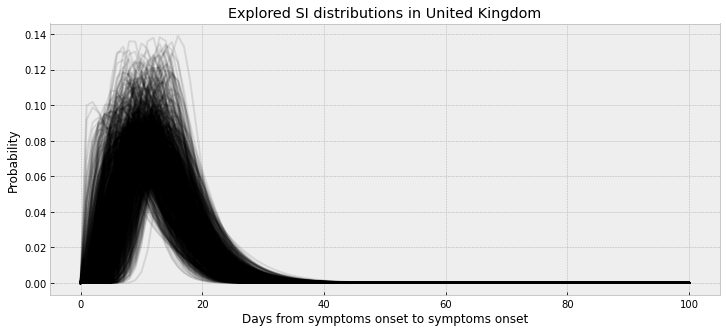

In [22]:
RR = None
Rs = []

for country in DF.Country.unique():
    I = DF[DF.Country==country]

    T = int(DATA.loc[DATA.country==country, "length"].values[0])
    #T = I.Cases.argmax()
    
    R = estimate_R0(
        I, country,
        T=T,
        muLo=7.55, muUp=17.29,
        sdLo=2.88, sdUp=7.26
        #muLo=12.42-.01, muUp=12.41+.01, #test
        #sdLo=5.07-.01, sdUp=5.07+.01, #test
    )
    if RR is None:
        RR = R["stats"]
    else:
        RR = pd.concat([RR, R["stats"]])
    Rs = np.concatenate([Rs, R["samples"]])
    
    a, loc, scale = sps.gamma.fit(R["samples"])
    R_dis = sps.gamma(a=a, loc=loc, scale=scale)
    R_x = np.linspace(R_dis.ppf(.0001), R_dis.ppf(.9999), 100)
    R_y = R_dis.pdf(R_x)
    
    with plt.style.context("bmh"):
        fig, ax = plt.subplots(figsize=(12, 5))
        plt.hist(R["samples"], alpha=.5, density=True, label="histogram")
        plt.plot(R_x, R_y, lw=1, label="Gamma fit")
        plt.axvline(R_dis.mean(), ls=":", label=f"mean {R_dis.mean():.2f}")
        plt.axvline(R_dis.median(), ls="--", label=f"median {R_dis.median():.2f}")
        R_lo = R_dis.ppf(.025)
        R_up = R_dis.ppf(.975)
        plt.plot([R_lo, R_up], [.025, .025], lw=4, label="95% CI")
        plt.legend()
        plt.title(f"MPX early $R_0$ estimate in {country} (window {T} days from outbreak)")
        plt.xlabel("basic reproduction number")
        plt.ylabel("probability density")
        fig.savefig(f"plots/figure2/R0 {country}.pdf", bbox_inches="tight")
        plt.show()
        
    with plt.style.context("bmh"):
        fig, ax = plt.subplots(figsize=(12, 5))
        for SI in R["explored_SI"]:
            plt.plot(SI["x"], SI["y"], "k", alpha=.1)
        plt.title(f"Explored SI distributions in {country}")
        plt.xlabel("Days from symptoms onset to symptoms onset")
        plt.ylabel("Probability")
        fig.savefig(f"plots/figure3/SI_{country}.pdf", bbox_inches="tight")
        plt.show()

In [23]:
RR

,Country,Mean,Median,Quantile_0.005,Quantile_0.025,Quantile_0.050,Quantile_0.250,Quantile_0.750,Quantile_0.950,Quantile_0.975,Quantile_0.995
0,Belgium,1.686742,1.675640,1.284406,1.365561,1.409998,1.559711,1.801681,2.001361,2.070984,2.213984
0,France,2.547447,2.486399,1.625848,1.770466,1.858041,2.191910,2.836665,3.445243,3.670701,4.152255
0,Germany,3.574114,3.416501,1.968412,2.170493,2.304108,2.868400,4.109083,5.382398,5.870328,6.934042
0,Italy,2.966570,2.901610,1.717081,1.932590,2.058242,2.515977,3.346517,4.096593,4.369238,4.944661
0,Netherlands,2.221170,2.176268,1.471709,1.594393,1.667438,1.940346,2.453191,2.928160,3.102707,3.473648
0,Portugal,3.551448,3.401984,1.799037,2.040467,2.194466,2.818467,4.122323,5.418783,5.909440,6.971193
0,Spain,2.421441,2.367774,1.608805,1.736495,1.813779,2.108223,2.676357,3.212298,3.410797,3.834705
0,Switzerland,1.916389,1.888173,1.319753,1.425863,1.486973,1.706277,2.095804,2.442090,2.567083,2.829705
0,United Kingdom,2.022223,1.996822,1.444095,1.549172,1.609162,1.822151,2.194654,2.521963,2.639487,2.885581


In [24]:
RRc = RR.copy(deep=True)
RRc.columns = RRc.columns.str.replace("Quantile_", "Q_")

In [25]:
RRc.set_index("Country").round(2).to_csv("R0.csv")

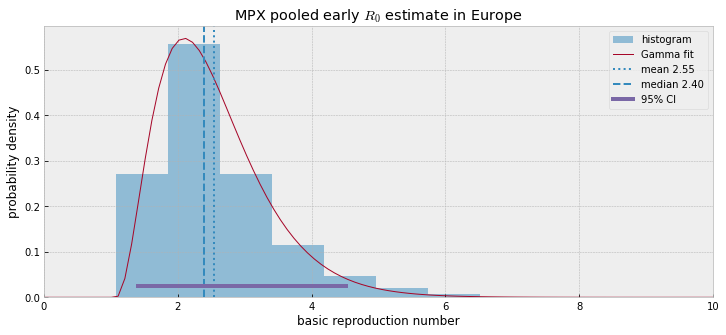

In [26]:
with plt.style.context("bmh"):
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.hist(Rs, alpha=.5, density=True, label="histogram")
    a, loc, scale = sps.gamma.fit(Rs)
    Rs_d = sps.gamma(a=a, loc=loc, scale=scale)
    Rs_x = np.linspace(0, 10, 100)
    Rs_y = Rs_d.pdf(Rs_x)
    plt.plot(Rs_x, Rs_y, lw=1, label="Gamma fit")
    plt.axvline(Rs_d.mean(), ls=":", label=f"mean {Rs_d.mean():.2f}")
    plt.axvline(Rs_d.median(), ls="--", label=f"median {Rs_d.median():.2f}")
    Rs_lo = Rs_d.ppf(.025)
    Rs_up = Rs_d.ppf(.975)
    plt.plot([Rs_lo, Rs_up], [.025, .025], lw=4, label="95% CI")
    plt.legend()
    plt.title("MPX pooled early $R_0$ estimate in Europe")
    plt.xlabel("basic reproduction number")
    plt.ylabel("probability density")
    plt.xlim([0, 10])
    fig.savefig("plots/figure0/R0_EU.pdf", bbox_inches="tight")
    plt.show()

In [27]:
np.round(Rs_d.mean(),2), np.round(Rs_d.median(),2), np.round(Rs_d.ppf(.025),2), np.round(Rs_d.ppf(.975), 2)

(2.55, 2.4, 1.41, 4.51)

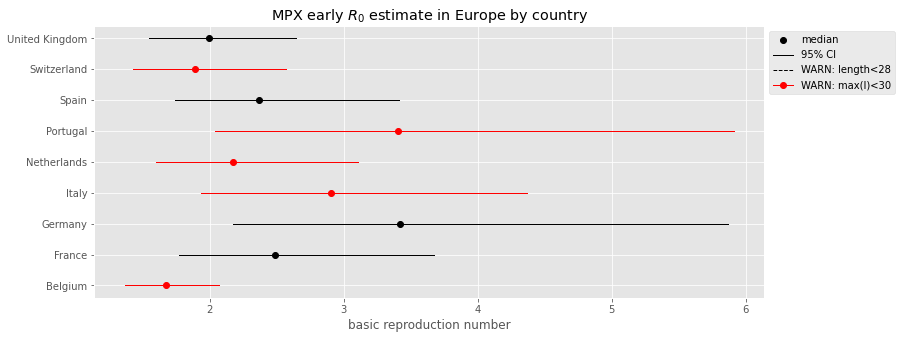

In [28]:
with plt.style.context("ggplot"):
    fig, ax = plt.subplots(figsize=(12, 5))
    for c in RR.Country.unique():
        _R = RR[RR.Country==c]
        color = "k"
        ls = "-"
        if WARNINGS[WARNINGS.country==c]["max incidence"].values[0] == "WARN":
            color = "r"
        if WARNINGS[WARNINGS.country==c].length.values[0] == "WARN":
            ls = "--"
        ax.plot(_R.Median, c, 'o', c=color)
        ax.plot(
            [_R["Quantile_0.025"].values[0], _R["Quantile_0.975"].values[0]], [c, c], 
            lw=1, color=color, ls=ls)
        plt.title("MPX early $R_0$ estimate in Europe by country")
    plt.xlabel("basic reproduction number")
    legend = [
        Line2D([0], [0], marker='o', color='k', label='median', markerfacecolor='k', lw=0),
        Line2D([0], [0], color='k', label='95% CI', markerfacecolor='k', lw=1),
        Line2D([0], [0], color='k', label='WARN: length<28', lw=1, ls="--"),
        Line2D([0], [0], marker='o', color='r', label='WARN: max(I)<30', markerfacecolor='r', lw=1),
    ]
    plt.legend(handles=legend, loc="upper left", bbox_to_anchor=(1,1))
    fig.savefig("plots/figure0/R0_countries.pdf", bbox_inches="tight")
    plt.show()

In [29]:
string = ""
for c in countries.values:
    string += c+", "
string

'Austria, Belgium, France, Germany, Italy, Netherlands, Portugal, Spain, Switzerland, United Kingdom, '

In [30]:
countries.size

10

In [31]:
DATA.columns

Index(['country', '1st cases', 'max incidence', 'length', 'max_date'], dtype='object')

In [43]:
DW = pd.DataFrame()

In [44]:
DW["country"] = DATA.country

In [45]:
DW["1st cases"] = DATA["1st cases"].astype(str) + " " + WARNINGS["1st cases"]

In [46]:
DW["max incidence"] = DATA["max incidence"].astype(str) + " " + WARNINGS["max incidence"]

In [47]:
DW["length"] = DATA["length"].fillna(0).astype(int).astype(str) + " " + WARNINGS["length"]

In [48]:
DW.set_index("country", inplace=True)

In [49]:
DW = DW[DW.length!="0 "]

In [50]:
DW.to_csv("countries.csv")

In [ ]:
# test

In [ ]:
de = pd.read_csv("Germany_1918.csv", parse_dates=["Date"], index_col="Date")

In [ ]:
ax = de.plot()
plt.axvline(de.index[28])

In [ ]:
de.head(5)

In [ ]:
index = sensitivity_analysis(
    de, "Germany 1918",
    Ts=de.reset_index().Cases.idxmax(),
    minT=de.reset_index().Cases.idxmax()//2,
    muLo=2.99, muUp=3.01,
    sdLo=1.49, sdUp=1.51,
    save=False
)

In [ ]:
index

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(de)
plt.axvline(de.index[index[1]], color="k", ls="--")

In [ ]:
I = de

R = estimate_R0(
    I, "Germany 1918",
    T=27,
    muLo=3-.01, muUp=3+.01,
    sdLo=1.5-.01, sdUp=1.5+.01
)

a, loc, scale = sps.gamma.fit(R["samples"])
R_dis = sps.gamma(a=a, loc=loc, scale=scale)
R_x = np.linspace(R_dis.ppf(.0001), R_dis.ppf(.9999), 100)
R_y = R_dis.pdf(R_x)

with plt.style.context("bmh"):
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.hist(R["samples"], alpha=.5, density=True, label="histogram")
    plt.plot(R_x, R_y, lw=1, label="Gamma fit")
    plt.axvline(R_dis.mean(), ls=":", label="mean")
    plt.axvline(R_dis.median(), ls="--", label="median")
    R_lo = R_dis.ppf(.025)
    R_up = R_dis.ppf(.975)
    plt.plot([R_lo, R_up], [.025, .025], lw=4, label="95% CI")
    plt.legend()
    plt.title(f"MPX early $R_0$ estimate in Germany 1918")
    plt.xlabel("basic reproduction number")
    plt.ylabel("probability density")
    plt.show()

In [ ]:
R_dis.mean(), R_dis.median(), R_dis.ppf(.025), R_dis.ppf(.975)

In [ ]:
for si in R["explored_SI"]:
    plt.plot(si["x"], si["y"], "k", alpha=.1)

In [ ]:
# test 2

In [ ]:
mu = 12.42
sd = 5.07

sh = mu**2 / sd**2
ra = mu / sd**2

In [ ]:
R0 = 2.86
T = 73
_dis = sps.gamma(a=sh, scale=1/ra)
print(_dis.mean(), _dis.std())
SI = _dis.pdf(np.arange(0,T))
SI /= SI.sum()

fig, ax = plt.subplots(figsize=(12, 4))
I = np.zeros(T+SI.size)
I[0] = 1
for t in range(T):
    I[t:(t+SI.size)] += R0 * I[t] * SI
    plt.plot(I)
#plt.plot(de.Cases.values)
plt.show()
I = np.round(I[:T])

In [ ]:
with plt.style.context("bmh"):
    plt.plot(I);

In [ ]:
plt.plot(np.arange(0,T+1)[1:], SI)

In [ ]:
date_start = pd.to_datetime("2022-01-01")
date_end = date_start + pd.Timedelta(days=I.size-1)

In [ ]:
ts = pd.DataFrame({
    "Date": pd.date_range(start=date_start, end=date_end),
    "Cases": I
})
ts.set_index("Date", inplace=True)

In [ ]:
ts.Cases.values.astype(int)

In [ ]:
mu, sd

In [ ]:
index = sensitivity_analysis(
    ts, "Test sample",
    Ts=ts.reset_index().Cases.idxmax(),
    minT=ts.reset_index().Cases.idxmax()//2,
    muLo=mu-.1, muUp=mu+.1,
    sdLo=sd-.1, sdUp=sd+.1,
    save=False, pairs=10,
    plot_sim=False
)

In [ ]:
R = estimate_R0(
    ts, "Test sample",
    T=ts.index.size,
    #T=index[1],
    muLo=mu-.01, muUp=mu+.01,
    sdLo=sd-.01, sdUp=sd+.01,
)

a, loc, scale = sps.gamma.fit(R["samples"])
R_dis = sps.gamma(a=a, loc=loc, scale=scale)
R_x = np.linspace(R_dis.ppf(.0001), R_dis.ppf(.9999), 100)
R_y = R_dis.pdf(R_x)

In [ ]:
with plt.style.context("bmh"):
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.hist(R["samples"], alpha=.5, density=True, label="histogram")
    plt.plot(R_x, R_y, lw=1, label="Gamma fit")
    plt.axvline(R_dis.mean(), ls=":", label="mean")
    plt.axvline(R_dis.median(), ls="--", label="median")
    R_lo = R_dis.ppf(.025)
    R_up = R_dis.ppf(.975)
    plt.plot([R_lo, R_up], [.025, .025], lw=4, label="95% CI")
    plt.axvline(R0, ls=":", color="k", label="real R0")
    plt.legend()
    plt.title(f"MPX early $R_0$ estimate in Test Sample")
    plt.xlabel("basic reproduction number")
    plt.ylabel("probability density")
    plt.show()

In [ ]:
R_dis.mean(), R_dis.ppf(.025), R_dis.ppf(.975)